# 延后初始化
:label:`sec_deferred_init`

到目前为止，我们忽略了建立网络时需要做的以下这些事情：

* 我们定义了网络架构，但没有指定输入维度。
* 我们添加层时没有指定前一层的输出维度。
* 我们在初始化参数时，甚至没有足够的信息来确定模型应该包含多少参数。

有些读者可能会对我们的代码能运行感到惊讶。
毕竟，深度学习框架无法判断网络的输入维度是什么。
这里的诀窍是框架的*延后初始化*（defers initialization），
即直到数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。

在以后，当使用卷积神经网络时，
由于输入维度（即图像的分辨率）将影响每个后续层的维数，
有了该技术将更加方便。
现在我们在编写代码时无须知道维度是什么就可以设置参数，
这种能力可以大大简化定义和修改模型的任务。
接下来，我们将更深入地研究初始化机制。

## 实例化网络

首先，让我们实例化一个多层感知机。


# 自定义层

## 不带参数的层

In [1]:
import torch
import torch.nn.functional as F
from torch import nn


class CenteredLayer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
    def forward(self,x):
        return x-x.mean()

In [2]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [3]:
# 将层作为组件合并到构建更复杂的模型中
net = nn.Sequential(nn.Linear(8,128),CenteredLayer())

Y = net(torch.rand(4,8))
Y.mean()

tensor(4.1910e-09, grad_fn=<MeanBackward0>)

## 不带参数的层

In [6]:
class MyLinear(nn.Module):
    def __init__(self,in_units,units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units,units))     #输入×输出的矩阵
        self.bias = nn.Parameter(torch.randn(units,))
        
        
    def forward(self,X):
        linear = torch.matmul(X,self.weight.data)+self.bias.data    # 全连接层中的矩阵乘法
        return F.relu(linear)
    
    

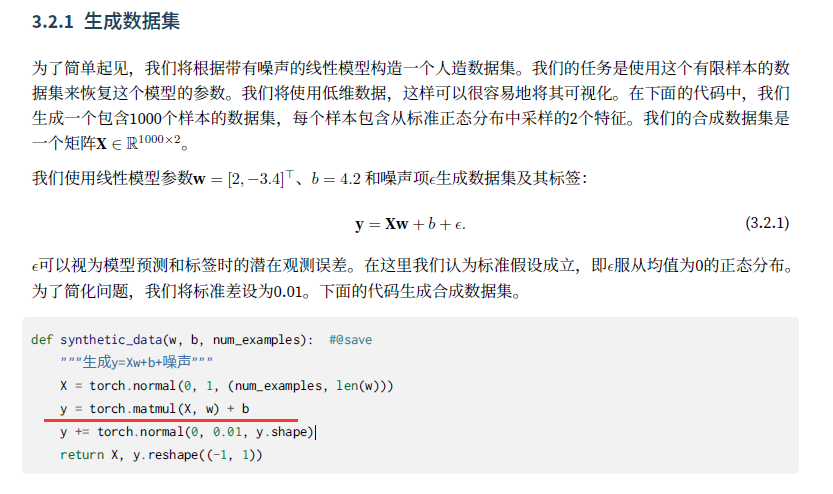

In [7]:
dense = MyLinear(5,3)
dense.weight

Parameter containing:
tensor([[ 0.6724,  0.0018, -0.3937],
        [ 1.2213,  0.6478,  0.4692],
        [-0.3439,  1.4577, -1.0447],
        [-0.9607, -0.2974,  0.2523],
        [ 0.8203, -0.4336,  1.0325]], requires_grad=True)

In [8]:
#使用自定义层直接执行正向传播
dense(torch.rand(2,5))

tensor([[0.1256, 0.5422, 0.0000],
        [0.0460, 0.4331, 0.0000]])

In [14]:
#使用自定义层构建模型
net = nn.Sequential(MyLinear(64,8),MyLinear(8,1))
net(torch.rand(2,64))

tensor([[ 0.0000],
        [10.0227]])

此时，因为输入维数是未知的，所以网络不可能知道输入层权重的维数。
因此，框架尚未初始化任何参数，我们通过尝试访问以下参数进行确认。


接下来让我们将数据通过网络，最终使框架初始化参数。


一旦我们知道输入维数是20，框架可以通过代入值20来识别第一层权重矩阵的形状。
识别出第一层的形状后，框架处理第二层，依此类推，直到所有形状都已知为止。
注意，在这种情况下，只有第一层需要延迟初始化，但是框架仍是按顺序初始化的。
等到知道了所有的参数形状，框架就可以初始化参数。

## 小结

* 延后初始化使框架能够自动推断参数形状，使修改模型架构变得容易，避免了一些常见的错误。
* 我们可以通过模型传递数据，使框架最终初始化参数。

## 练习

1. 如果指定了第一层的输入尺寸，但没有指定后续层的尺寸，会发生什么？是否立即进行初始化？
1. 如果指定了不匹配的维度会发生什么？
1. 如果输入具有不同的维度，需要做什么？提示：查看参数绑定的相关内容。


[Discussions](https://discuss.d2l.ai/t/5770)
